In [2]:
import numpy as np
from matplotlib import pyplot as plt

### The superconductivity dataset

The superconductivity dataset (Hamidieh, Computational Materials Science, 2018) contains $d=81$ chemical and molecular features extracted from 21263 superconductors along with the critical temperature (the label) in the last column. The goal is to predict the critical temperature from the features. If you are interested in the physical meaning of those, you can check out the original paper at https://arxiv.org/pdf/1803.10260.pdf

In the first part we will predict the critical temperature using least-square linear regression; in the second part we will train a neural network by gradient descent to predict the temperature.

## 0 Loading and pre-processing

Download the dataset from `https://archive.ics.uci.edu/dataset/464/superconductivty+data` (24MB). The dataset we use is `train.csv` ; move it to the folder containing the notebook. In the following cell we load it. `data` contains the numerical values while `fields` of size $d+1$ is the name of the features.

In [3]:
fields = np.loadtxt("train.csv", delimiter=",", max_rows=1, dtype=str)
data = np.loadtxt("train.csv", delimiter=",", skiprows=1)

For each sample (each compound) the following features are given. The critical temperature we want to regress is the last one.

In [4]:
print(fields)

['"number_of_elements"' '"mean_atomic_mass"' '"wtd_mean_atomic_mass"'
 '"gmean_atomic_mass"' '"wtd_gmean_atomic_mass"' '"entropy_atomic_mass"'
 '"wtd_entropy_atomic_mass"' '"range_atomic_mass"'
 '"wtd_range_atomic_mass"' '"std_atomic_mass"' '"wtd_std_atomic_mass"'
 '"mean_fie"' '"wtd_mean_fie"' '"gmean_fie"' '"wtd_gmean_fie"'
 '"entropy_fie"' '"wtd_entropy_fie"' '"range_fie"' '"wtd_range_fie"'
 '"std_fie"' '"wtd_std_fie"' '"mean_atomic_radius"'
 '"wtd_mean_atomic_radius"' '"gmean_atomic_radius"'
 '"wtd_gmean_atomic_radius"' '"entropy_atomic_radius"'
 '"wtd_entropy_atomic_radius"' '"range_atomic_radius"'
 '"wtd_range_atomic_radius"' '"std_atomic_radius"'
 '"wtd_std_atomic_radius"' '"mean_Density"' '"wtd_mean_Density"'
 '"gmean_Density"' '"wtd_gmean_Density"' '"entropy_Density"'
 '"wtd_entropy_Density"' '"range_Density"' '"wtd_range_Density"'
 '"std_Density"' '"wtd_std_Density"' '"mean_ElectronAffinity"'
 '"wtd_mean_ElectronAffinity"' '"gmean_ElectronAffinity"'
 '"wtd_gmean_ElectronAffin

**0.1** How many samples do we have ? What is the critical temperature of the 10th sample?

In [5]:
ds = (data.shape)
critical_T_index = ds[1] -1 #we remove 1 bc list starts at index 0 and we know that the critical temperature is the last future
print(f"We have {ds[0]} samples")
print(f"The critical temperature of the 10th sample is {data[9, critical_T_index]} K") #data[9,..] also because indexs start at 0

We have 21263 samples
The critical temperature of the 10th sample is 31.0 K


**0.2** `data` is of size $(N, d+1)$. The last column is the critical temperature. Extract it to form two numpy arrays : $y$ of size $(N,)$ containing the critical temperature and $X$ of size $(N,d)$ containing the remaining data.

In [6]:
y = data[:, -1]  
X = data[:, :-1]  
#just to make sure :
print(data.shape)
print(y.shape)
print(X.shape)


(21263, 82)
(21263,)
(21263, 81)


**0.3** Because the different features correspond to different physical quantities and have different units, thus different magnitudes of numerical values, we preprocess the arrays.

Compute $m_y$ the mean of $y$ and $\sigma_y$ its standard deviation. Then normalize and update $y$ accroding to $y\to (y-m_y)/\sigma_y$, where $y-m_y$ means that we substract the mean $m_y$ from each component of the vector $y$. Do the same for each column of $X$ i.e. for the mean of each feature across all datapoints. Use numpy functions and no `for` loop.

In [7]:
mY, stdY = np.mean(y), np.std(y)
y = (y - mY) / stdY

mX, stdX = np.mean(X, axis=0), np.std(X, axis=0) #axis = 0 specify that we compute those values for each column
X = (X - mX) / stdX

**0.4** Write a function `split` that given $X$ and $y$ returns a shuffled train, validation and test set with a 70%‑15%-15% split.

In [8]:
#We can inspire from serie 5 ex 2.1
#don't forge to import train_test_split
from sklearn.model_selection import train_test_split
def split(X, y):
    
    X_train,X_tv,y_train,y_tv=train_test_split(X,y,shuffle=True, train_size=0.7)
    X_val,X_test,y_val,y_test=train_test_split(X_tv,y_tv,shuffle=True, train_size=0.5)

    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split(X, y)

## 1 Least-square linear regression

In this part we predict $y$ using least-square regression. More precisely we express our predictor $\hat{y}$ as a linear combination of the features $\hat{y}=Xw$ with $w\in\mathbb{R}^d$. We search for $w$ that minimizes the mean square error $L_\mathrm{train}$ between the predictions and the true values.
$$L_\mathrm{train}=\frac{1}{2}\frac{1}{\#\mathrm{train}}\sum_{n\in\mathrm{train}}(y_n-\hat{y}_n)^2 \qquad\qquad L_\mathrm{test}=\frac{1}{2}\frac{1}{\#\mathrm{test}}\sum_{n\in\mathrm{test}}(y_n-\hat{y}_n)^2$$


**1.1** Compute $w^*$ the minimizer of $L$ using the formula for the least-square estimator without regularization on the train set. Compute $\hat y_\mathrm{train}$ and $\hat y_\mathrm{test}$ the predicted values for the train and test sets. Compute and print the mean errors $L_\mathrm{train}$ and $L_\mathrm{test}$ you obtain with this estimator.

In [10]:
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train #we use formula (3.36) from the course
y_train_predicted = X_train@ w
y_test_predicted = X_test @ w

#we use the same 1/2 factor that in the énoncé (it is useful to simplify the derivatives of L)
L_train = 0.5 * np.mean((y_train - y_train_predicted) ** 2)
L_test = 0.5 * np.mean((y_test - y_test_predicted) ** 2)


print(f"L_train: {L_train}")
print(f"L_test: {L_test}")

L_train: 0.1328308857229481
L_test: 0.12905833153610863


**1.2** Plot the predicted temperature vs the true one for the samples from the test set. Use a scatter plot with small dots and add labels. Do not forget to rescale $y$ with $m_y$ and $\sigma_y$ to obtain physical temperatures. Plot the line $y=\hat y$.

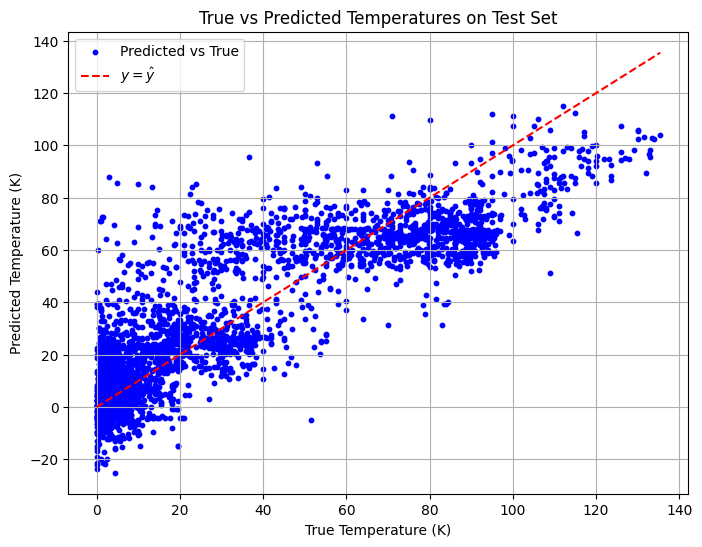

In [11]:
y_test_rescaled = y_test * stdY + mY  # Rescale true y_test
y_test_predicted_rescaled = y_test_predicted * stdY + mY  # Rescale predicted y_test

plt.figure(figsize=(8, 6))
plt.scatter(y_test_rescaled, y_test_predicted_rescaled, s=10, color='blue', label='Predicted vs True')  # Small dots
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], 'r--', label='$y=\\hat{y}$')  # Line y = predicted y


plt.xlabel('True Temperature (K)')
plt.ylabel('Predicted Temperature (K)')
plt.title('True vs Predicted Temperatures on Test Set')
plt.legend()
plt.grid(True)
plt.show()



**1.3** In this case it is not required to add a regularization term on $w$ ; justify why.

*your answer* :
A regularization term is necessary when $n < d $   ($n$ representing in our case the number of sample and $d$ the number of features) for  $data\in\mathbb{R}^{n\times d}$  because the solution that minimize the loss function L is not unique anymore and we decide to pick the one with the smallest norm. As $n > d$ in this exercice this term is not necessary.

## 2 Small neural network and gradient descent

One can construct better estimators by combining the columns of $X$ to create new features. For instance you already saw bits of polynomial features where we extend $X=(X_{i\mu})$ with powers of the data $X_{i\mu}^k$.

In this part we follow a different way. We let a neural network automatically constructs features from data, by combining it in a non-linear manner. We consider a simple neural network with two layers. Given data $X\in\mathbb{R}^{M\times d}$ it returns the prediction $\hat y\in\mathbb{R}^M$ defined by
$$
\hat y=f(X;W_1,W_2)=\sigma(XW_2+\mathrm{1_M}B^T)W_1
$$
where we set
* $W_1\in\mathbb{R}^p$ and $W_2\in\mathbb{R}^{d\times p}$ the two layers of weights,
* $B\in\mathbb{R}^p$ the biaises, $\mathrm{1_M}\in\mathbb{R}^M$ the vector full of ones, and $\mathrm{1_M}B^T$ is the matrix where each row is $B$,
* $p$ the number of hidden units,
* $\sigma$ is the activation function that acts element-wise on the matrix $XW_2+\mathrm{1_M}B^T$. We take $\sigma(x)=max(0,x)$.

We consider the same training loss as in the first part :
$$L_\mathrm{train}(W_1,W_2,B)=\frac{1}{2N'}\sum_{n=1}^{N'}(y_{\mathrm{train},n}-\hat y_{\mathrm{train},n})^2 \qquad\qquad \hat y_\mathrm{train}=f(X_\mathrm{train};W_1,W_2,B) \qquad\qquad N'=\#\mathrm{train}$$
We seek to minimize $L_\mathrm{train}$ with respect to $W_1$, $W_2$ and $B$. For this, we use gradient descent. The descent has to be done on the three sets of parameters $W_1$, $W_2$ and $B$ at the same time beause we want to minimize $L$ with respect to each of them.

**2.1** In the image classification tutorial you saw that one can use the logistic loss instead of the square loss, and that it is often more efficient. Why here do we prefer the quadratic loss ?

*your answer* The answer that we are predicting in a classification is binary (1 or 0) and we saw that the logistic loss was the most appropriate for this but here we are dealing with a regression problem where we want to be able to measure how far we are from the predicted value and the square loss is thus more appropriate in this context 

**2.2** We do gradient descent on the parameters $W_1$, $W_2$ and $B$, with a step size $\gamma$. We write $\nabla_{W_1}L\in\mathbb{R}^p$, $\nabla_{W_2}L\in\mathbb{R}^{d\times p}$ and $\nabla_{B}L\in\mathbb{R}^p$ the gradients of $L_\mathrm{train}$ with respect to them. We define the gradient of a function $g$ with respect to a vector $A$ or a matrix $C$ as the vector or the matrix of same dimensions with
$$
(\nabla_A g)_i = \frac{\partial g}{\partial A_i} \qquad\qquad (\nabla_C g)_{ij} = \frac{\partial g}{\partial C_{ij}}\ .
$$
Given $W_1^{(t)}$, $W_2^{(t)}$ and $B^{(t)}$ the values of $W_1$, $W_2$ and $B$ at iteration $t$ of gradient descent, write down their values $W_1^{(t+1)}$, $W_2^{(t+1)}$ and $B^{(t+1)}$ at the next iteration (one line for each).

*your answer*
$$
W_1^{(t+1)} = W_1^{(t)} - \gamma \nabla_{W_1} L
$$

$$
W_2^{(t+1)} = W_2^{(t)} - \gamma \nabla_{W_2} L
$$

$$
B^{(t+1)} = B^{(t)} - \gamma \nabla_{B} L
$$

**2.3** We use the chain rule to compute $\nabla_{W_1}L$, $\nabla_{W_2}L$ and $\nabla_BL$. It states that
$$
\nabla_{W_1}L = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_{W_1}f \qquad\qquad \nabla_{W_2}L = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_{W_2}f \qquad\qquad \nabla_BL = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_Bf
$$
with $\nabla_{W_1}f\in\mathbb{R}^{N'\times p}$, $\nabla_{W_2}f\in\mathbb{R}^{N'\times d\times p}$ and $\nabla_Bf\in\mathbb{R}^{N'\times p}$ the gradients of $f$ with respect to $W_1$, $W_2$ and $B$.

$\nabla_{\hat y_\mathrm{train}}L$ is the gradient of $L_\mathrm{train}$ with respect to $\hat y_\mathrm{train}$. Show in two lines that $\nabla_{\hat y_\mathrm{train}}L=(\hat y_\mathrm{train}-y_\mathrm{train})/N'$. Compute $\nabla_{W_1}f$ and then $\nabla_{W_1}L$.

*your answer*

# 1
We are given the loss function:

$$
L_{\text{train}}(W_1, W_2, B) = \frac{1}{2N'} \sum_{n=1}^{N'} (y_{\text{train},n} - \hat{y}_{\text{train},n})^2
$$

To find the gradient of the loss with respect to $( \hat{y}_{\text{train}} )$, we differentiate the above loss function:

$$
\nabla_{\hat{y}_{\text{train}}} L = \frac{1}{2N'} \sum_{n=1}^{N'} 2 (\hat{y}_{\text{train},n} - y_{\text{train},n})
 = \frac{(\hat{y}_{\text{train}} - y_{\text{train}})}{N'}
$$

---

## 2)

The function \( f \) is given by:

$$
\hat{y} = f(X; W_1, W_2, B) = \sigma(XW_2 + \mathrm{1_M} B^T) W_1
$$

Since sigma is not a function of W_1 we use the product derivative rule and hence find :

$$
\nabla_{W_1} f = \sigma(XW_2 + \mathrm{1_M} B^T)
$$

---

## 3)

Now, using the chain rule and the result from Step 2, we have:

$$
\nabla_{W_1} L = (\nabla_{\hat{y}_{\text{train}}} L)^T \nabla_{W_1} f
$$

Substitute $( \nabla_{\hat{y}_{\text{train}}} L = \frac{(\hat{y}_{\text{train}} - y_{\text{train}})}{N'} )$ and $( \nabla_{W_1} f = \sigma(XW_2 + \mathrm{1_M} B^T) )$:

$$
\nabla_{W_1} L = \left( \frac{(\hat{y}_{\text{train}} - y_{\text{train}})}{N'} \right)^T \sigma(XW_2 + \mathrm{1_M} B^T)
$$


**2.4** We give an implementation of $\nabla_{W_2}L$ and $\nabla_BL$. Implement functions that compute $\sigma$, $\sigma'$, $f$, $L$ and $\nabla_{W_1}L$. They should be vectorized to be fast enough.

In [16]:
def sigma(x):
    """
    activation function
    """
    return np.maximum(0,x) #python built-in function. Is going to act element wise
    

def deriv_sigma(x):
    """
    derivative of the activation function
    """
    return np.where(x > 0, 1, 0) # the derivatif if 1 if x>0 since d(sigma)/dx = dx/dx = 1 in this case. Returns 0 otherwise

def neural_net(X,W_1,W_2,B): 
    """
    function implementing the neural network f
    W_1 is a (p,) array
    W_2 is a (d, p) array
    B is a (p,) array
    X is a (n, d) array
    """
    return sigma((X @ W_2 + ( np.ones(B.size) @B.T) ) @ W_1 )

def loss(y,z):
    """
    quadratic loss
    y and z are (n,) arrays
    """
    return 0.5 * np.mean((y - z) ** 2)

def grad_W_1(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_1
    """
    N = y.shape[0]  
    
    Z = X @ W_2 + np.ones(B.size) @B.T  
    A = sigma(Z)     # Apply activation function
    y_pred = A @ W_1  # Predicted values
    
    grad = ((y_pred - y) / N) @ A 
    
    return grad
    
def grad_W_2(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_2
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return np.einsum('n,p,np,nd->dp', z-y, W_1, deriv_sigma(pre_activations), X)/len(y)

def grad_B(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to B
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return (z-y)@(deriv_sigma(pre_activations)*W_1)/len(y)

**2.5** Implement the gradient descent. You shall :
* compute and save the value of the train loss at each iteration ; same for the validation loss ;
* stop the gradient descent after a fixed well-chosen number $t_\mathrm{max}$ of iterations ;
* plot the train and validation losses with labels and a legend, using a log-log scale ;
* tune $\gamma$ to obtain good results with reasonable computing time. Remember that large $\gamma$ is unstable and small $\gamma$ is slow.

You should :
* start from weights randomly initialised, each component of $W_1$ as a Gaussian with zero mean and variance 1 and each component of $W_2$ as a Gaussian with zero mean and variance $1/d$. Take $B$ all zeros ;
* take $p=5$ ;
* check that the train loss decreases ;
* while debugging your code take $t_\mathrm{max}$ not too large. Once it runs correctly take a larger $t_\mathrm{max}$ to obtain a better test loss.

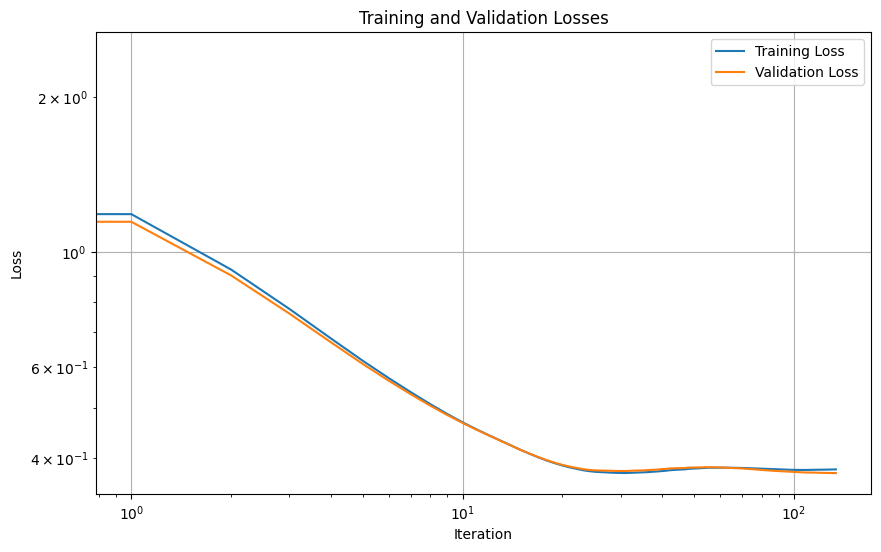

In [17]:
tMax= 135 #we found it be trying tMax = 1000 and saw it was the minimum
p=5
gamma= 0.01 #while trying multiple ones we found that it was a reasonable one 
d = X.shape[1]
W_1 = np.random.normal(loc=0.0, scale=1.0, size=(p,))        
W_2 = np.random.normal(loc=0.0, scale=np.sqrt(1/d), size=(d, p)) 
B= np.zeros(p)
train_losses=[]
val_losses=[]
for t in range(tMax):
    y_train_pred = neural_net(X_train, W_1, W_2, B)  # Training predictions
    y_val_pred = neural_net(X_val, W_1, W_2, B)      # Validation predictions

    train_loss = loss(y_train, y_train_pred)  
    val_loss = loss(y_val, y_val_pred)        
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # If we want to print the loss at each iteration uncoment the next line
    #print(f"Iteration {t+1}/{tMax}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    grad_W1 = grad_W_1(X_train, W_1, W_2, B, y_train) 
    grad_W2 = grad_W_2(X_train, W_1, W_2, B, y_train)  
    gradd_B = grad_B(X_train, W_1, W_2, B, y_train)      # we name it gradd_B because grad_B is already the name of our function

    #we then update the parametres
    W_1 -= gamma * grad_W1
    W_2 -= gamma * grad_W2
    B -= gamma * gradd_B


plt.figure(figsize=(10, 6))
plt.loglog(train_losses, label='Training Loss')
plt.loglog(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



**2.6** Once we have optimized the training compute the test loss of the trained model and print it. In this case does the model overfit ?

In [18]:
y_test_pred = neural_net(X_test, W_1, W_2, B)

test_loss = loss(y_test, y_test_pred)

print(f"Test Loss: {test_loss:.4f}")

final_train_loss = train_losses[-1]  
final_val_loss = val_losses[-1]    

#The following tests can determine that we are not overfitting but could not rigourosly testify that we are 
#as the difference between the test and the train loss could be negligible

if final_train_loss < test_loss:
    print("The model is likely overfitting.")
else:
    print("The model generalizes well.")

Test Loss: 0.3738
The model generalizes well.


**2.7** Using your trained neural network predict the temperature of the 10th sample of the test set and compare to the true value.

In [19]:
print(f" the predicted temperature for the 10th sample of the test set is {y_test_pred[9]} with an actual value of {y_test[9]}")

 the predicted temperature for the 10th sample of the test set is 0.22898769432192606 with an actual value of -0.9698326858932868


## Note :
We are significantly more accurate than in the first exercice where we used linear regression (we should try more prediction to make sure tough). 

## Sources : 
I have used chatGPT and haven't discussed with anybody about my answers.